In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nibabel as nib
import pandas as pd
from hmmlearn import hmm
import scipy.stats as scp
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
import random
import pickle
import os

sns.set(context='talk',style='white')

hbn_folder = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study'
project_folder = '/Users/catcamacho/Library/CloudStorage/Box-Box/SEAL/stickystates'
ts_folder = '/Volumes/EXTERNAL/HBN/subject_folders'
data_folder = os.path.join(project_folder, 'DATA','hbn')
out_folder = os.path.join(project_folder, 'ANALYSIS','hbn_brain_states_final', 'k3')

sample_file = os.path.join(hbn_folder,'social_proc_networks','dynamic_connectivity','DATA', 
                           'helper_files','sample_gord.32k_fs_LR.pscalar.nii')
# get parcel and network labels
parcel_labels = nib.load(sample_file).header.get_axis(1).name
network_labels = []
for s in parcel_labels:
    b = s.split('_')
    if len(b)<2:
        network_labels.append(b[0])
    else:
        network_labels.append(b[1])
network_labels = np.array(network_labels)
network_names, network_sizes = np.unique(network_labels, return_counts=True)

# define measures of interest
networks_of_interest = ['Auditory', 'CinguloOperc', 'Default', 'DorsalAttn', 'FrontoParietal',
                        'SMhand', 'SMmouth', 'Salience', 'VentralAttn', 'Visual']
networks_palette = ['#FF00FF','#800080','#FF0000','#00FF00','#FFFF00','#00FFFF','#FF8000',
                    '#000000','#008080','#0000BD']

features_of_interest = ['Positive','Negative','Anger','Happy','Fear','Sad','Excited','Brightness',
                        'SaliencyFract','Sharpness','Vibrance','Loudness','Motion']
timing = np.round(np.arange(0,600,0.8),1) # for DM

state_palette = ['#7F7F7F','#05159b', '#cf28cf', '#008c8c']

In [9]:
def compile_ts_data(subdf, movie, datadir, outfile, motionfile):
    """
    combine data for each movie together into 1 file
    
    Parameters
    ----------
    subdf: DataFrame
        A dataframe with subject IDs as the index. Includes IDs for all usable data.
    movie: str
        Corresponds with the str for the movie content to concatenate (e.g., "DM" or "TP").
    datadir: folder path
        Path to folder with the subject timeseries ciftis.
    outfile: file path
        Path including filename to save the output data of shape Ntimepoints x Nparcels x Nsubjects.
    
    Returns
    -------
    data: numpy array
        The compiled data of shape Ntimepoints x Nparcels x Nsubjects
    """
    
    if not isinstance(subdf, pd.DataFrame):
        subdf = pd.read_csv(subdf, index_col=0)
    
    for sub in subdf.index:
        file = '{0}/{1}/{1}_task-movie{2}_bold1_AP_Atlas_demean_detrend_resid0.9_filt_gordon.32k_fs_LR.ptseries.nii'.format(datadir,sub, movie)
        motion = np.loadtxt('{0}/{1}/{1}_task-movie{2}_bold1_AP_FD.txt'.format(datadir,sub, movie))
        if sub == subdf.index[0]:
            data = StandardScaler().fit_transform(nib.load(file).get_fdata())
            data = np.expand_dims(data, axis=2)
            motiondata = np.expand_dims(motion, axis=1)
        else:
            t = StandardScaler().fit_transform(nib.load(file).get_fdata())
            t = np.expand_dims(t, axis=2)
            motion = np.expand_dims(motion, axis=1)
            data = np.concatenate([data,t],axis=2)
            motiondata = np.concatenate([motiondata,motion],axis=1)
    
    print('Compile data from {0} brain regions measured at {1} timepoints from {2} participants.'.format(data.shape[1],data.shape[0],data.shape[2]))
    np.save(outfile, data)
    np.save(motionfile, motiondata)


subinfo = pd.read_csv(os.path.join(data_folder, 'sampleinfo_movieDM.csv'), index_col=0)
outfile = os.path.join(data_folder, 'compiled_ts_data_movieDM.npy')
motionfile = os.path.join(data_folder, 'compiled_motion_data_movieDM.npy')

compile_ts_data(subinfo, 'DM', ts_folder, outfile, motionfile)

Compile data from 394 brain regions measured at 750 timepoints from 620 participants.


# train model on Despicable Me and find optimal states

In [10]:
movie='DM'
subinfo = pd.read_csv(os.path.join(data_folder, 'sampleinfo_movie{0}.csv'.format(movie)), index_col=0)
func_file = os.path.join(data_folder, 'compiled_ts_data_movie{0}.npy'.format(movie))
motion = np.load(os.path.join(data_folder, 'compiled_motion_data_movie{0}.npy'.format(movie)))
func_data = np.load(func_file)
net_func_data = np.empty((func_data.shape[0], len(networks_of_interest), func_data.shape[2]))
for i, n in enumerate(networks_of_interest):
    net_func_data[:,i,:] = np.mean(func_data[:,network_labels==n,:], axis=1)

# split data into discovery and replication
disc_data = net_func_data[:,:, subinfo['site']=='rubic']
disc_motion = motion[:, subinfo['site']=='rubic']
disc_info = subinfo.loc[subinfo['site']=='rubic',:]

t_concat_disc = []
for i in range(0, disc_data.shape[2]):
    m = disc_motion[:,i]
    t = disc_data[:,:,i]
    t_concat_disc.append(t[m<0.9,:])
t_concat_disc = np.concatenate(t_concat_disc, axis=0)

rep_data = net_func_data[:,:, subinfo['site']=='cbic']
rep_motion = motion[:, subinfo['site']=='cbic']
rep_info = subinfo.loc[subinfo['site']=='cbic',:]

t_concat_rep = []
for i in range(0, rep_data.shape[2]):
    t = rep_data[:,:,i]
    m = rep_motion[:,i]
    t_concat_rep.append(t[m<0.9,:])
t_concat_rep = np.concatenate(t_concat_rep, axis=0)

# save datasets
np.save(os.path.join(data_folder, 'movie{0}_disc_concat_data.npy'.format(movie)), t_concat_disc)
np.save(os.path.join(data_folder, 'movie{0}_rep_concat_data.npy'.format(movie)), t_concat_rep)

In [ ]:
model_fit = pd.DataFrame()

for k in range(2,20):
    print(k)
    model = hmm.GMMHMM(n_components=k, covariance_type="full", n_iter=10000)
    model.fit(t_concat_disc)

    # save scores
    train_score = model.score(t_concat_disc)
    test_score, _ = model.decode(t_concat_rep)
    n_params = model.covars_.shape[0]*model.covars_.shape[1]*model.covars_.shape[2]
    test_a = -2*test_score + 2*n_params
    test_b = -2*test_score + n_params*np.log(t_concat_rep.shape[0])

    model_fit.loc[k, 'n_states'] = k
    model_fit.loc[k,'train_ll'] = train_score
    model_fit.loc[k,'test_ll'] = test_score
    model_fit.loc[k,'test_aic'] = test_a
    model_fit.loc[k,'test_bic'] = test_b

In [18]:
model_fit

,n_states,train_ll,test_ll,test_aic,test_bic
2,2.0,-1.542792e+06,-1.335988e+06,2.672016e+06,2.672220e+06
3,3.0,-1.484137e+06,-1.292799e+06,2.585658e+06,2.585965e+06
4,4.0,-1.437709e+06,-1.257056e+06,2.514192e+06,2.514601e+06
5,5.0,-1.402415e+06,-1.228118e+06,2.456336e+06,2.456848e+06
6,6.0,-1.374736e+06,-1.207136e+06,2.414393e+06,2.415007e+06
7,7.0,-1.349906e+06,-1.190615e+06,2.381370e+06,2.382087e+06
8,8.0,-1.330273e+06,-1.171954e+06,2.344069e+06,2.344888e+06
9,9.0,-1.310398e+06,-1.157248e+06,2.314676e+06,2.315598e+06
10,10.0,-1.295615e+06,-1.146851e+06,2.293902e+06,2.294926e+06
11,11.0,-1.280201e+06,-1.134548e+06,2.269316e+06,2.270442e+06


In [23]:
model_fit_d = model_fit.diff()
model_fit_d

,n_states,train_ll,test_ll,test_aic,test_bic
2,NaN,NaN,NaN,NaN,NaN
3,1.0,58655.332315,43188.753890,-86357.507781,-86255.098548
4,1.0,46428.215472,35743.240725,-71466.481450,-71364.072217
5,1.0,35294.181937,28937.664682,-57855.329364,-57752.920132
6,1.0,27678.985967,20981.713385,-41943.426771,-41841.017538
7,1.0,24829.152053,16521.612462,-33023.224925,-32920.815692
8,1.0,19633.652487,18660.409968,-37300.819937,-37198.410704
9,1.0,19875.217941,14706.349320,-29392.698640,-29290.289407
10,1.0,14782.695759,10397.210104,-20774.420209,-20672.010976
11,1.0,15413.878317,12302.986143,-24585.972287,-24483.563054


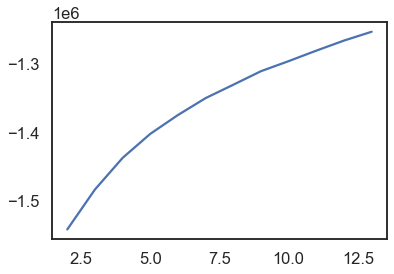

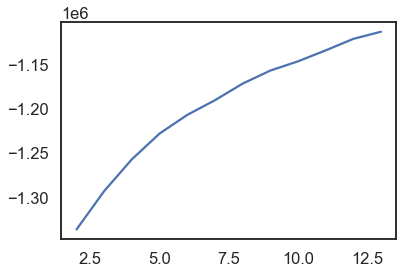

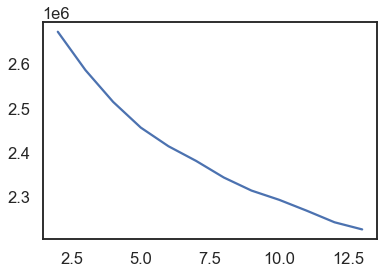

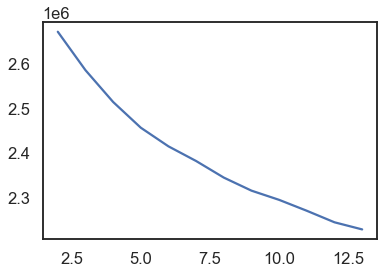

In [19]:
plt.plot(model_fit['n_states'],model_fit['train_ll'])
plt.savefig(os.path.join(out_folder,'movieDM_train_model_fit_plot.png'))
plt.show()
plt.close()

plt.plot(model_fit['n_states'],model_fit['test_ll'])
plt.savefig(os.path.join(out_folder,'movieDM_test_model_fit_plot.png'))
plt.show()
plt.close()

plt.plot(model_fit['n_states'],model_fit['test_aic'])
plt.savefig(os.path.join(out_folder,'movieDM_test_model_fit_aic_plot.png'))
plt.show()
plt.close()

plt.plot(model_fit['n_states'],model_fit['test_bic'])
plt.savefig(os.path.join(out_folder,'movieDM_test_model_fit_bic_plot.png'))
plt.show()
plt.close()

model_fit.to_csv(os.path.join(out_folder,'movieDM_model_fit_stats.csv'))

## fit and save optimal model

In [2]:
movie='DM'
nstates=3
t_concat_disc = np.load(os.path.join(data_folder, 'movie{0}_disc_concat_data.npy'.format(movie)))

# fit and save optimal model
model = hmm.GMMHMM(n_components=nstates, covariance_type="full", n_iter=10000)
model.fit(t_concat_disc)

# save outputs
pickle.dump(model, open(os.path.join(out_folder,'movieDM_k{0}_model.pkl'.format(nstates)), 'wb'))

#### Compute CIs

In [26]:
# load data and set up model
movie='DM'
nstates=3
train_data_file = os.path.join(data_folder, 'movie{0}_disc_concat_data.npy'.format(movie))
model = pickle.load(open(os.path.join(out_folder,'movieDM_k{0}_model.pkl'.format(nstates)), 'rb'))

# bootstrapping parameters
nboots = 1000
lowern = 0.1
uppern = 0.3
ci = 95
samplen = np.load(train_data_file).shape[0]

boot_results = np.empty((nstates, nstates, nboots))

for i in range(nboots):
    # subset data
    bootsample_size = random.randint(int(samplen*lowern),int(samplen*uppern))
    subsampmask = np.full(samplen, 0)
    subsampmask[:bootsample_size] = 1
    start = random.randint(0,samplen-int(samplen*uppern))
    subsampmask = np.roll(subsampmask, start)
    temp = np.load(train_data_file)[subsampmask==1,:]
    res = model.decode(temp)[1]
    
    # fit the model
    transitions = np.zeros((nstates, nstates))
    for j in range(res.shape[0]-1):
        s = res[j]
        sn = res[j+1]
        transitions[s,sn] = transitions[s,sn]+1
    marg0_subtra = np.sum(transitions, axis=0)
    boot_results[:,:,i] = transitions/marg0_subtra

In [28]:
means = np.mean(boot_results, axis=2)
lowerCI = np.percentile(boot_results, (100-ci)/2, axis=2, keepdims=True)
upperCI = np.percentile(boot_results, 100-((100-ci)/2), axis=2, keepdims=True)

results = pd.DataFrame()
for a in range(nstates):
    for b in range(nstates):
        results.loc['s{0}_s{1}'.format(a+1,b+1), 'mean'] = means[a,b]
        results.loc['s{0}_s{1}'.format(a+1,b+1), 'lowerCI'] = lowerCI[a,b]
        results.loc['s{0}_s{1}'.format(a+1,b+1), 'upperCI'] = upperCI[a,b]
results.to_csv(os.path.join(out_folder, 'transition_probabilities_CI_k3.csv'))

## apply model to all participant data

In [5]:
nstates=3
movie='DM'
model = pickle.load(open(os.path.join(out_folder,'movieDM_k{0}_model.pkl'.format(nstates)), 'rb'))

subinfo = pd.read_csv(os.path.join(data_folder, 'sampleinfo_movie{0}.csv'.format(movie)), index_col=0)
net_func_data = np.load(os.path.join(data_folder, 'movie{0}_sample-full_net_data.npy'.format(movie)))
func_data = np.load(os.path.join(data_folder, 'compiled_ts_data_movie{0}.npy'.format(movie)))

# make mean activation maps
ax0 = nib.load(sample_file).header.get_axis(0)
ax1 = nib.load(sample_file).header.get_axis(1)

mean_netact_df = pd.DataFrame()
state_info_df = pd.DataFrame()
sample_states = []
state_prob = {0:pd.DataFrame(columns=timing, dtype=float, index=subinfo.index),
              1:pd.DataFrame(columns=timing, dtype=float, index=subinfo.index),
              2:pd.DataFrame(columns=timing, dtype=float, index=subinfo.index),
              3:pd.DataFrame(columns=timing, dtype=float, index=subinfo.index)}
ind = 0

mean_act = {'s0':[],'s1':[], 's2':[],'s3':[]}

for i, sub in enumerate(subinfo.index):
    sub_data = np.squeeze(nib.load(os.path.join(ts_folder, sub, '{0}_task-movieDM_bold1_AP_Atlas_demean_detrend_resid0.9_filt_gordon.32k_fs_LR.ptseries.nii'.format(sub))).get_fdata())
    sub_data = StandardScaler().fit_transform(sub_data)
    net_func_data = np.empty((sub_data.shape[0], len(networks_of_interest)))
    for i, n in enumerate(networks_of_interest):
        net_func_data[:,i] = np.mean(sub_data[:,network_labels==n], axis=1)
    motion = np.loadtxt(os.path.join(ts_folder, sub, '{0}_task-movieDM_bold1_AP_FD.txt'.format(sub)))
    res = np.zeros((net_func_data.shape[0],))
    res[motion<0.9] = model.decode(net_func_data[motion<0.9,:])[1] + 1
    sample_states.append(np.expand_dims(res,0))
    prob = model.predict_proba(net_func_data)
    prob[motion>=0.9,:] = np.nan
    np.save(os.path.join(out_folder,'sub','{0}_movie{1}_k{2}_states.npy'.format(sub, movie, nstates)), res)
    np.save(os.path.join(out_folder,'sub','{0}_movie{1}_k{2}_state_probabilities.npy'.format(sub, movie, nstates)), prob)
    for s in range(1, nstates+1): 
        mask = res==s
        state_info_df.loc[sub,'s{0}_percent'.format(s)] = np.nanmean(mask)*100
        if s in res:
            state_prob[s].loc[sub,:] = prob[:,s-1]
            pa = np.mean(sub_data[mask,:], axis=0)
            mean_act['s{0}'.format(s)].append(np.expand_dims(pa, axis=1))
            na=net_func_data[mask,:]
            mean_netact_df.loc[ind,'sub'] = sub
            mean_netact_df.loc[ind,'state'] = s
            mean_netact_df.loc[ind,networks_of_interest] = np.mean(na, axis=0)
            ind = ind + 1
group_data = np.concatenate(sample_states, axis=0)
group_data = np.squeeze(group_data)
np.save(os.path.join(out_folder,'group-movie{0}_k{1}_states.npy'.format(movie, nstates)), group_data)

In [6]:
for s in range(1,nstates+1):
    mean_act_data = np.mean(np.concatenate(mean_act['s{0}'.format(s)],axis=1), axis=1)
    img = nib.cifti2.cifti2.Cifti2Image(np.expand_dims(mean_act_data, axis=0), (ax0, ax1))
    nib.save(img, os.path.join(out_folder, 'movie{0}_k{2}_state{1}.32k_fs_LR.pscalar.nii'.format(movie, s, nstates)))

state_info_df.to_csv(os.path.join(out_folder, 'movie{0}_states_info.csv'.format(movie)))
mean_netact_df.to_csv(os.path.join(out_folder, 'movie{0}_mean_netact.csv'.format(movie)))
pickle.dump(mean_act, open(os.path.join(out_folder,'movie{0}_k{1}_state_activation.pkl'.format(movie, nstates)), 'wb'))
pickle.dump(state_prob, open(os.path.join(out_folder,'movie{0}_k{1}_state_probabilities.pkl'.format(movie, nstates)), 'wb'))

## Compute individual transition odds ratios

In [9]:
odds_ratios = pd.DataFrame()
subinfo = pd.read_csv(os.path.join(data_folder, 'sampleinfo_movieDM.csv'), index_col=0)
for sub in subinfo.index:
    substates = np.load(os.path.join(out_folder,'sub','{0}_movieDM_k{1}_states.npy'.format(sub, nstates))).astype(int)
    # overall video
    subtransitions = np.zeros((nstates+1, nstates+1))
    for i in range(1, substates.shape[0]-1):
        s = substates[i]
        sn = substates[i+1]
        subtransitions[s,sn] = subtransitions[s,sn]+1
    marg0_subtra = np.sum(subtransitions, axis=0)
    odds = subtransitions/marg0_subtra
    states = np.arange(1,nstates+1).astype(int).tolist()
    for s1 in states:
        for s2 in states:
            odds_ratios.loc[sub,'ntrans_s{0}_to_{1}_all'.format(s1,s2)] = subtransitions[s1,s2]
    for s1 in states:
        for s2 in states:
            odds_ratios.loc[sub,'s{0}_to_{1}_all'.format(s1,s2)] = odds[s1,s2]
    for i in range(1, nstates+1):
        states = np.arange(1,nstates+1).astype(int).tolist()
        states.remove(i)
        odds_ratios.loc[sub,'s{0}_to_{1}vs{2}_ratio_all'.format(i, states[0],states[1])] = odds[i,states[0]]/odds[i,states[1]]
        odds_ratios.loc[sub,'s{0}_to_{1}vs{2}_ratio_all'.format(i, states[1],states[0])] = odds[i,states[1]]/odds[i,states[0]]
odds_ratios = odds_ratios.replace(np.inf,np.nan)
odds_ratios.to_csv(os.path.join(out_folder, 'movieDM_sample_oddsratios.csv'))

/var/folders/c_/ms_vv4qx13d2z86m53sfcf1m0000gq/T/ipykernel_2876/1001030004.py:12: RuntimeWarning: invalid value encountered in divide
  odds = subtransitions/marg0_subtra
/var/folders/c_/ms_vv4qx13d2z86m53sfcf1m0000gq/T/ipykernel_2876/1001030004.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  odds_ratios.loc[sub,'s{0}_to_{1}vs{2}_ratio_all'.format(i, states[0],states[1])] = odds[i,states[0]]/odds[i,states[1]]


In [10]:
odds_ratios

,ntrans_s1_to_1_all,ntrans_s1_to_2_all,ntrans_s1_to_3_all,ntrans_s2_to_1_all,ntrans_s2_to_2_all,ntrans_s2_to_3_all,ntrans_s3_to_1_all,ntrans_s3_to_2_all,ntrans_s3_to_3_all,s1_to_1_all,...,s2_to_3_all,s3_to_1_all,s3_to_2_all,s3_to_3_all,s1_to_2vs3_ratio_all,s1_to_3vs2_ratio_all,s2_to_1vs3_ratio_all,s2_to_3vs1_ratio_all,s3_to_1vs2_ratio_all,s3_to_2vs1_ratio_all
sub-NDARAA504CRN,257.0,9.0,11.0,7.0,188.0,7.0,13.0,5.0,251.0,0.927798,...,0.026022,0.046931,0.024752,0.933086,1.089559,0.917803,0.971119,1.029740,1.896029,0.527418
sub-NDARAA948VFH,269.0,9.0,15.0,9.0,173.0,3.0,15.0,3.0,252.0,0.918089,...,0.011111,0.051195,0.016216,0.933333,0.875676,1.141975,2.764505,0.361728,3.156997,0.316757
sub-NDARAB458VK9,272.0,8.0,13.0,7.0,175.0,7.0,14.0,6.0,246.0,0.928328,...,0.026316,0.047782,0.031746,0.924812,0.866097,1.154605,0.907850,1.101504,1.505119,0.664399
sub-NDARAB977GFB,308.0,8.0,18.0,12.0,129.0,1.0,13.0,5.0,254.0,0.924925,...,0.003663,0.039039,0.035211,0.930403,0.854460,1.170330,9.837838,0.101648,1.108709,0.901950
sub-NDARAC331VEH,311.0,10.0,10.0,7.0,149.0,6.0,12.0,3.0,240.0,0.942424,...,0.023438,0.036364,0.018519,0.937500,1.580247,0.632812,0.905051,1.104911,1.963636,0.509259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-NDARZW363UGM,268.0,11.0,11.0,12.0,147.0,2.0,10.0,2.0,199.0,0.896321,...,0.009174,0.033445,0.011696,0.912844,1.274854,0.784404,4.374582,0.228593,2.859532,0.349708
sub-NDARZW873DN3,183.0,16.0,8.0,13.0,252.0,8.0,12.0,5.0,251.0,0.879808,...,0.029963,0.057692,0.018315,0.940075,1.956044,0.511236,2.085938,0.479401,3.150000,0.317460
sub-NDARZW930MF2,210.0,11.0,10.0,5.0,219.0,8.0,15.0,3.0,267.0,0.913043,...,0.028070,0.065217,0.012876,0.936842,1.345494,0.743222,0.774457,1.291228,5.065217,0.197425
sub-NDARZX163EWC,303.0,9.0,15.0,8.0,146.0,5.0,15.0,4.0,243.0,0.929448,...,0.019011,0.046012,0.025157,0.923954,0.992453,1.007605,1.290798,0.774715,1.828988,0.546751


## make plots

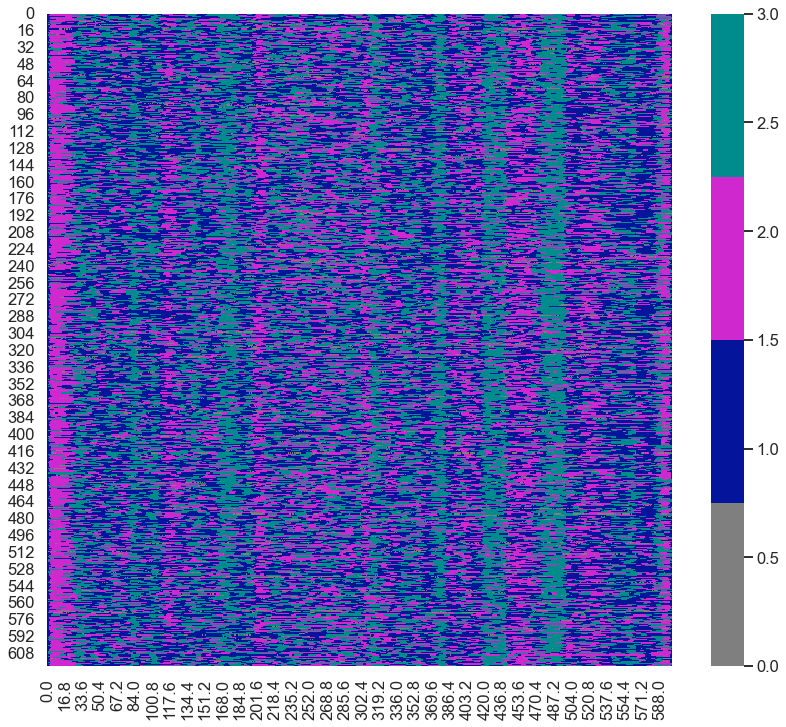

In [14]:
# plot overall brain states for each movie
state_palette = ['#05159b', '#cf28cf', '#008c8c']
nstates=3
group_data = np.load(os.path.join(out_folder,'group-movieDM_k{0}_states.npy'.format(nstates)))


# plot states across the sample
sample_res_df = pd.DataFrame(group_data, columns=timing)
sns.set(context='talk', style='white')
plt.figure(figsize=(14,12))
sns.heatmap(sample_res_df, cmap=['#7F7F7F']+state_palette)
plt.savefig(os.path.join(out_folder,'group-movieDM_k{0}_states_sample.png'.format(nstates)), dpi=300)

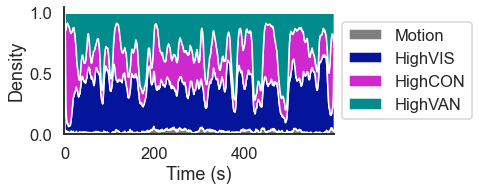

In [16]:
group_data = np.load(os.path.join(out_folder,'group-movieDM_k3_states.npy'))
sample_res_df = pd.DataFrame(np.squeeze(group_data), columns=timing)

states_counts_df = pd.DataFrame()
for i in sample_res_df.columns:
    states_counts_df.loc[i,'s0'] = sum(sample_res_df[i]==0)
    states_counts_df.loc[i,'s1'] = sum(sample_res_df[i]==1)
    states_counts_df.loc[i,'s2'] = sum(sample_res_df[i]==2)
    states_counts_df.loc[i,'s3'] = sum(sample_res_df[i]==3)

data_perc = states_counts_df.divide(states_counts_df.sum(axis=1), axis=0)

# Make the plot
plt.figure(figsize=(7,3))
plt.stackplot(data_perc.index, data_perc["s0"], data_perc["s1"],  data_perc["s2"], data_perc["s3"],
              labels=[ 'Motion', 'HighVIS', 'HighCON','HighVAN'], 
              colors=['#7F7F7F']+ state_palette)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.xlim(0,timing[-1])
plt.ylabel('Density')
plt.xlabel('Time (s)')
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(out_folder,'group-movieDM_k3_states_density.png'), dpi=300)
plt.show()

In [113]:
# plot mean network activation per state
mean_netact_df = pd.read_csv(os.path.join(out_folder, 'movieDM_mean_netact.csv'), index_col=0)
for s in range(1,6):
    t = mean_netact_df.loc[mean_netact_df['state']==s]
    t = pd.melt(t, value_vars=networks_of_interest, var_name='network', value_name='mean_activation') 

    plt.figure()
    sns.catplot(data=t, kind='boxen',ci=None,x='network', y='mean_activation', 
                palette=networks_palette, height=8)
    #sns.stripplot(data=t,x='network', y='mean_activation',color='gray', alpha=0.1)
    plt.axhline(y=0, color='k', linestyle='-')
    plt.xticks(rotation=45, ha='right')
    plt.title('State {0}'.format(s))
    plt.ylabel('Activation (arbitrary units)')
    plt.xlabel('Network')
    plt.tight_layout()
    plt.savefig(os.path.join(out_folder,'group-movieDM_k5_state{0}_netmean_boxen.png'.format(s)), dpi=300)
    plt.close()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [114]:
# compute sig net activation/deactivation

mean_netact_df = pd.read_csv(os.path.join(out_folder, 'movieDM_mean_netact.csv'), index_col=0)
net_activation_stats = pd.DataFrame()
i = 0
for s in range(1,6):
    t = mean_netact_df.loc[mean_netact_df['state']==s]
    for net in networks_of_interest:
        tstat, pval = scp.ttest_1samp(t.loc[:,net], 0)
        net_activation_stats.loc[i, 'State'] = s
        net_activation_stats.loc[i, 'Network'] = net
        net_activation_stats.loc[i, 't-stat'] = tstat
        net_activation_stats.loc[i, 'pval'] = pval
        net_activation_stats.loc[i, 'df'] = len(t.loc[:,net]) - 1
        net_activation_stats.loc[i, 'sig'] = pval<0.05
        net_activation_stats.loc[i, 'fdr_sig'] = pval<(0.05/len(networks_of_interest))
        i = i + 1
net_activation_stats.to_csv(os.path.join(out_folder, 'movieDM_k3_netact_ttests.csv'))

# Relate brain states to movie data

In [18]:
def temporal_smooth(data, time, sampling_rate, window=4):
    """
    Parameters
    ----------
    data: numpy array
        1-D array with signal data to smooth.
    time: numpy array
        Time stamps in seconds for the signals to be smoothed.
    sampling_rate: float
        The sampling rate in Hz that the data were acquired in.
    window: int
        The size of the gaussian kernel to use for smoothing (must be even number).
    
    Returns
    -------
    smoothed: numpy array
        1-D array with smoothed data.
    
    """
    def gaussian(t, fwhm):
        return np.exp(-(4*np.log(2)*t**2)/fwhm**2)

    # create kernel
    n = len(time)
    k = int(window/2)
    gtime = np.arange(-k, k)/sampling_rate

    gauswin = gaussian(gtime, window)
    gauswin = gauswin/np.sum(gauswin)
    
    # zeropad the data
    pad_data = np.pad(data, (window,window), mode='constant', constant_values=0)
    
    # smooth data
    smoothed = np.zeros_like(pad_data)
    for i in range(k+1, n-k-1):
        smoothed[i] = np.sum(pad_data[i-k:i+k] * gauswin)
    # remove pad
    smoothed = smoothed[window:-window]
    return(smoothed)

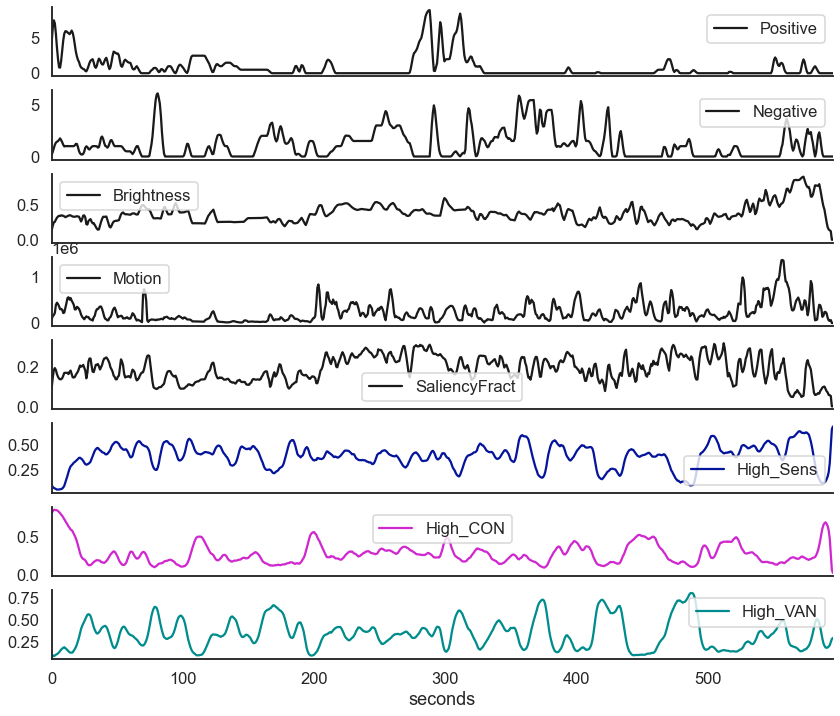

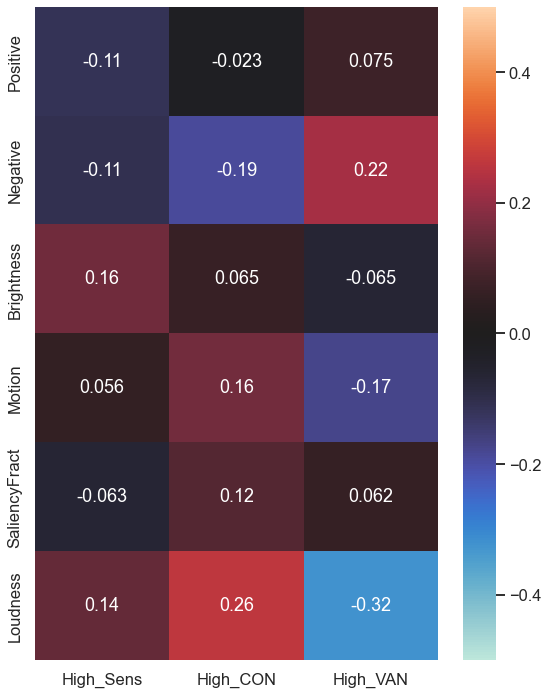

In [21]:
movie='DM'
mean_prob = pd.read_csv(os.path.join(out_folder, 'movie{0}_k3_meanprobs.csv'.format(movie)), index_col=0)

features = pd.read_csv(os.path.join(hbn_folder, 'HBN_video_coding','processing','v1','summary',
                                    '{0}_summary_codes_intuitivenames.csv'.format(movie)), index_col=0)
for f in features.columns:
    features.loc[:,f] = temporal_smooth(features.loc[:,f], timing, 1.2)
features = features.iloc[:-5,:]
mean_prob_trim = mean_prob.iloc[5:,:]
mean_prob_trim.columns = ['High_VIS','High_CON','High_VAN']
mean_prob_trim.index = features.index
combo = features.merge(mean_prob_trim, how='left', left_index=True, right_index=True)
combo[['Positive','Negative','Brightness','Motion','SaliencyFract', 'High_VIS','High_CON',
       'High_VAN']].plot(subplots=True, figsize=(14,12), xlim=(0,timing[-6]), 
                                  color=['k','k','k','k','k']+state_palette)
sns.despine()
plt.savefig(os.path.join(out_folder,'group-movie{0}_k3_mean_probabilities_features.png'.format(movie)), dpi=300)
plt.show()
plt.close()

c = combo.corr(method='spearman')
plt.figure(figsize=(8,10))
sns.heatmap(c.loc[['Positive','Negative','Brightness','Motion','SaliencyFract','Loudness'],
                  ['High_VIS','High_CON','High_VAN']], center=0, vmax=0.5, vmin=-0.5, annot=True)
plt.tight_layout()
plt.savefig(os.path.join(out_folder,'group-movie{0}_k3_corr_probabilities_features.png'.format(movie)), dpi=300)

In [25]:
for c in ['Positive','Negative','Brightness','Motion','SaliencyFract','Loudness']:
    for d in ['High_Sens','High_CON','High_VAN']:
        r, p = scp.spearmanr(combo[c], combo[d])
        print('{0} and {1} r = {2}, p = {3}'.format(c, d, round(r,2), round(p,3)))  

Positive and High_Sens r = -0.11, p = 0.002
Positive and High_CON r = -0.02, p = 0.534
Positive and High_VAN r = 0.08, p = 0.04
Negative and High_Sens r = -0.11, p = 0.003
Negative and High_CON r = -0.19, p = 0.0
Negative and High_VAN r = 0.22, p = 0.0
Brightness and High_Sens r = 0.16, p = 0.0
Brightness and High_CON r = 0.07, p = 0.074
Brightness and High_VAN r = -0.07, p = 0.075
Motion and High_Sens r = 0.06, p = 0.125
Motion and High_CON r = 0.16, p = 0.0
Motion and High_VAN r = -0.17, p = 0.0
SaliencyFract and High_Sens r = -0.06, p = 0.084
SaliencyFract and High_CON r = 0.12, p = 0.002
SaliencyFract and High_VAN r = 0.06, p = 0.091
Loudness and High_Sens r = 0.14, p = 0.0
Loudness and High_CON r = 0.26, p = 0.0
Loudness and High_VAN r = -0.32, p = 0.0


In [19]:
# get state info for during and outside of negative content
movie='DM'
subinfo = pd.read_csv(os.path.join(data_folder, 'sampleinfo_movie{0}.csv'.format(movie)), index_col=0)

#pull in features
features = pd.read_csv(os.path.join(hbn_folder, 'HBN_video_coding','processing','v1','summary',
                                    '{0}_summary_codes_intuitivenames.csv'.format(movie)), index_col=0)
for f in features.columns:
    features.loc[:,f] = temporal_smooth(features.loc[:,f], timing, 1.2)
features = features.iloc[:-5,:]
neg_mask = features['Negative']>1

# pull in network level activation
#func_net_data = np.load(os.path.join(data_folder, 'movie{0}_sample-full_net_data.npy'.format(movie)))[5:,:,:]

# set up dataframe for outputs
neg_df = pd.DataFrame()

for i, sub in enumerate(subinfo.index):
    sub_states = np.load(os.path.join(out_folder,'sub','{0}_movie{1}_k{2}_states.npy'.format(sub, movie, nstates)))[5:]
    sub_probs = np.load(os.path.join(out_folder,'sub','{0}_movie{1}_k{2}_state_probabilities.npy'.format(sub, movie, nstates)))[5:,:]
    for s in range(1,4): 
        # Get percent of time in each state
        sub_neg_mask = (sub_states==s) & neg_mask
        sub_nonneg_mask = (sub_states==s) & (neg_mask==False)
        neg_df.loc[sub,'neg_s{0}_pct'.format(s)] = np.nanmean(sub_neg_mask)*100
        neg_df.loc[sub,'nonneg_s{0}_pct'.format(s)] = np.nanmean(sub_nonneg_mask)*100
        
        # get mean probability for each state
        neg_df.loc[sub,'neg_s{0}_prob'.format(s)] = np.nanmean(sub_probs[sub_neg_mask,:][:, s-1])
        neg_df.loc[sub,'nonneg_s{0}_prob'.format(s)] = np.nanmean(sub_probs[sub_nonneg_mask,:][:, s-1])
        
        # get mean net activation for each state
        #if s in sub_states:
            #sub_data = func_net_data[:,:,i]
            #neg_net = sub_data[sub_neg_mask,:]
            #nonneg_net = sub_data[sub_nonneg_mask,:]
            #sub_neg_nets_labels = ['neg_s{0}_{1}'.format(s, n) for n in networks_of_interest]
            #sub_nonneg_nets_labels = ['nonneg_s{0}_{1}'.format(s, n) for n in networks_of_interest]
            #neg_df.loc[sub, sub_neg_nets_labels] = np.mean(neg_net, axis=0)
            #neg_df.loc[sub, sub_nonneg_nets_labels] = np.mean(nonneg_net, axis=0)

# save data
neg_df.to_csv(os.path.join(out_folder, 'movie{0}_neg_states_activation_info.csv'.format(movie)))

In [25]:

odds_ratios = pd.DataFrame()
subinfo = pd.read_csv(os.path.join(data_folder, 'sampleinfo_movie{0}.csv'.format(movie)), index_col=0)

#pull in features
features = pd.read_csv(os.path.join(hbn_folder, 'HBN_video_coding','processing','v1','summary',
                                    '{0}_summary_codes_intuitivenames.csv'.format(movie)), index_col=0)
for f in features.columns:
    features.loc[:,f] = temporal_smooth(features.loc[:,f], timing, 1.2)
features = features.iloc[:-5,:]
neg_mask = features['Negative']>1

for sub in subinfo.index:
    substates = np.load(os.path.join(out_folder,'sub','{0}_movie{1}_k3_states.npy'.format(sub, movie))).astype(int)
    substates = substates[5:][neg_mask==True]
    # overall video
    subtransitions = np.zeros((nstates+1, nstates+1))
    subdifftransitions = np.zeros((nstates+1, nstates+1))
    for i in range(substates.shape[0]-1):
        s = substates[i]
        sn = substates[i+1]
        subtransitions[s,sn] = subtransitions[s,sn]+1
    marg0_subtra = np.sum(subtransitions, axis=0)
    odds = subtransitions/marg0_subtra
    states = [1, 2, 3]
    for s1 in states:
        for s2 in states:
            odds_ratios.loc[sub,'s{0}_to_{1}_neg'.format(s1,s2)] = odds[s1,s2]
            odds_ratios.loc[sub,'ntrans_s{0}_to_{1}_neg'.format(s1,s2)] = subtransitions[s1,s2]
    for i in range(1, nstates+1):
        states = [1, 2, 3]
        states.remove(i)
        odds_ratios.loc[sub,'s{0}_to_{1}vs{2}_ratio_neg'.format(i, states[0],states[1])] = odds[i-1,states[0]]/odds[i-1,states[1]]
        odds_ratios.loc[sub,'s{0}_to_{1}vs{2}_ratio_neg'.format(i, states[1],states[0])] = odds[i-1,states[1]]/odds[i-1,states[0]]
odds_ratios = odds_ratios.replace(np.inf,np.nan)
odds_ratios.to_csv(os.path.join(out_folder, 'movie{0}_sample_oddsratios_neg.csv'.format(movie)))

/var/folders/c_/ms_vv4qx13d2z86m53sfcf1m0000gq/T/ipykernel_2876/2345336778.py:23: RuntimeWarning: invalid value encountered in divide
  odds = subtransitions/marg0_subtra
/var/folders/c_/ms_vv4qx13d2z86m53sfcf1m0000gq/T/ipykernel_2876/2345336778.py:32: RuntimeWarning: invalid value encountered in scalar divide
  odds_ratios.loc[sub,'s{0}_to_{1}vs{2}_ratio_neg'.format(i, states[0],states[1])] = odds[i-1,states[0]]/odds[i-1,states[1]]
/var/folders/c_/ms_vv4qx13d2z86m53sfcf1m0000gq/T/ipykernel_2876/2345336778.py:33: RuntimeWarning: invalid value encountered in scalar divide
  odds_ratios.loc[sub,'s{0}_to_{1}vs{2}_ratio_neg'.format(i, states[1],states[0])] = odds[i-1,states[1]]/odds[i-1,states[0]]
/var/folders/c_/ms_vv4qx13d2z86m53sfcf1m0000gq/T/ipykernel_2876/2345336778.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  odds_ratios.loc[sub,'s{0}_to_{1}vs{2}_ratio_neg'.format(i, states[1],states[0])] = odds[i-1,states[1]]/odds[i-1,states[0]]
/var/folders/c_/ms_vv4qx13d2z8

In [26]:
odds_ratios

,s1_to_1_neg,ntrans_s1_to_1_neg,s1_to_2_neg,ntrans_s1_to_2_neg,s1_to_3_neg,ntrans_s1_to_3_neg,s2_to_1_neg,ntrans_s2_to_1_neg,s2_to_2_neg,ntrans_s2_to_2_neg,...,s3_to_2_neg,ntrans_s3_to_2_neg,s3_to_3_neg,ntrans_s3_to_3_neg,s1_to_2vs3_ratio_neg,s1_to_3vs2_ratio_neg,s2_to_1vs3_ratio_neg,s2_to_3vs1_ratio_neg,s3_to_1vs2_ratio_neg,s3_to_2vs1_ratio_neg
sub-NDARAA504CRN,0.923729,109.0,0.070175,4.0,0.036496,5.0,0.025424,3.0,0.859649,49.0,...,0.070175,4.0,0.919708,126.0,NaN,NaN,25.310169,0.039510,0.029575,33.812865
sub-NDARAA948VFH,0.888889,96.0,0.038462,3.0,0.071429,9.0,0.037037,4.0,0.910256,71.0,...,0.051282,4.0,0.904762,114.0,NaN,NaN,12.444444,0.080357,0.040689,24.576923
sub-NDARAB458VK9,0.914062,117.0,0.095238,6.0,0.049587,6.0,0.023438,3.0,0.841270,53.0,...,0.063492,4.0,0.900826,109.0,NaN,NaN,18.433594,0.054249,0.027860,35.894180
sub-NDARAB977GFB,0.871212,115.0,0.092593,5.0,0.095238,12.0,0.053030,7.0,0.870370,47.0,...,0.037037,2.0,0.896825,113.0,NaN,NaN,9.147727,0.109317,0.060928,16.412698
sub-NDARAC331VEH,0.906977,117.0,0.070423,5.0,0.062500,7.0,0.038760,5.0,0.887324,63.0,...,0.042254,3.0,0.901786,101.0,NaN,NaN,14.511628,0.068910,0.043682,22.892958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-NDARZW363UGM,0.883721,114.0,0.078125,5.0,0.071429,7.0,0.054264,7.0,0.828125,53.0,...,0.046875,3.0,0.887755,87.0,2.296875,0.435374,12.372093,0.080827,0.065526,15.261161
sub-NDARZW873DN3,0.840000,84.0,0.103896,8.0,0.059259,8.0,0.080000,8.0,0.857143,66.0,...,0.038961,3.0,0.918519,124.0,NaN,NaN,14.175000,0.070547,0.093333,10.714286
sub-NDARZW930MF2,0.777778,42.0,0.059406,6.0,0.038217,6.0,0.055556,3.0,0.900990,91.0,...,0.039604,4.0,0.917197,144.0,NaN,NaN,20.351852,0.049136,0.061661,16.217822
sub-NDARZX163EWC,0.891892,99.0,0.060606,4.0,0.059259,8.0,0.027027,3.0,0.924242,61.0,...,0.015152,1.0,0.918519,124.0,NaN,NaN,15.050676,0.066442,0.029242,34.196970
